# SPeDE:  
## References relative uniqueness distance denrogram & OIU abundance barplot

#### Script written by Charles Dumolin for LM-UGent, 01-12-2018


C:\Users\cdumolin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


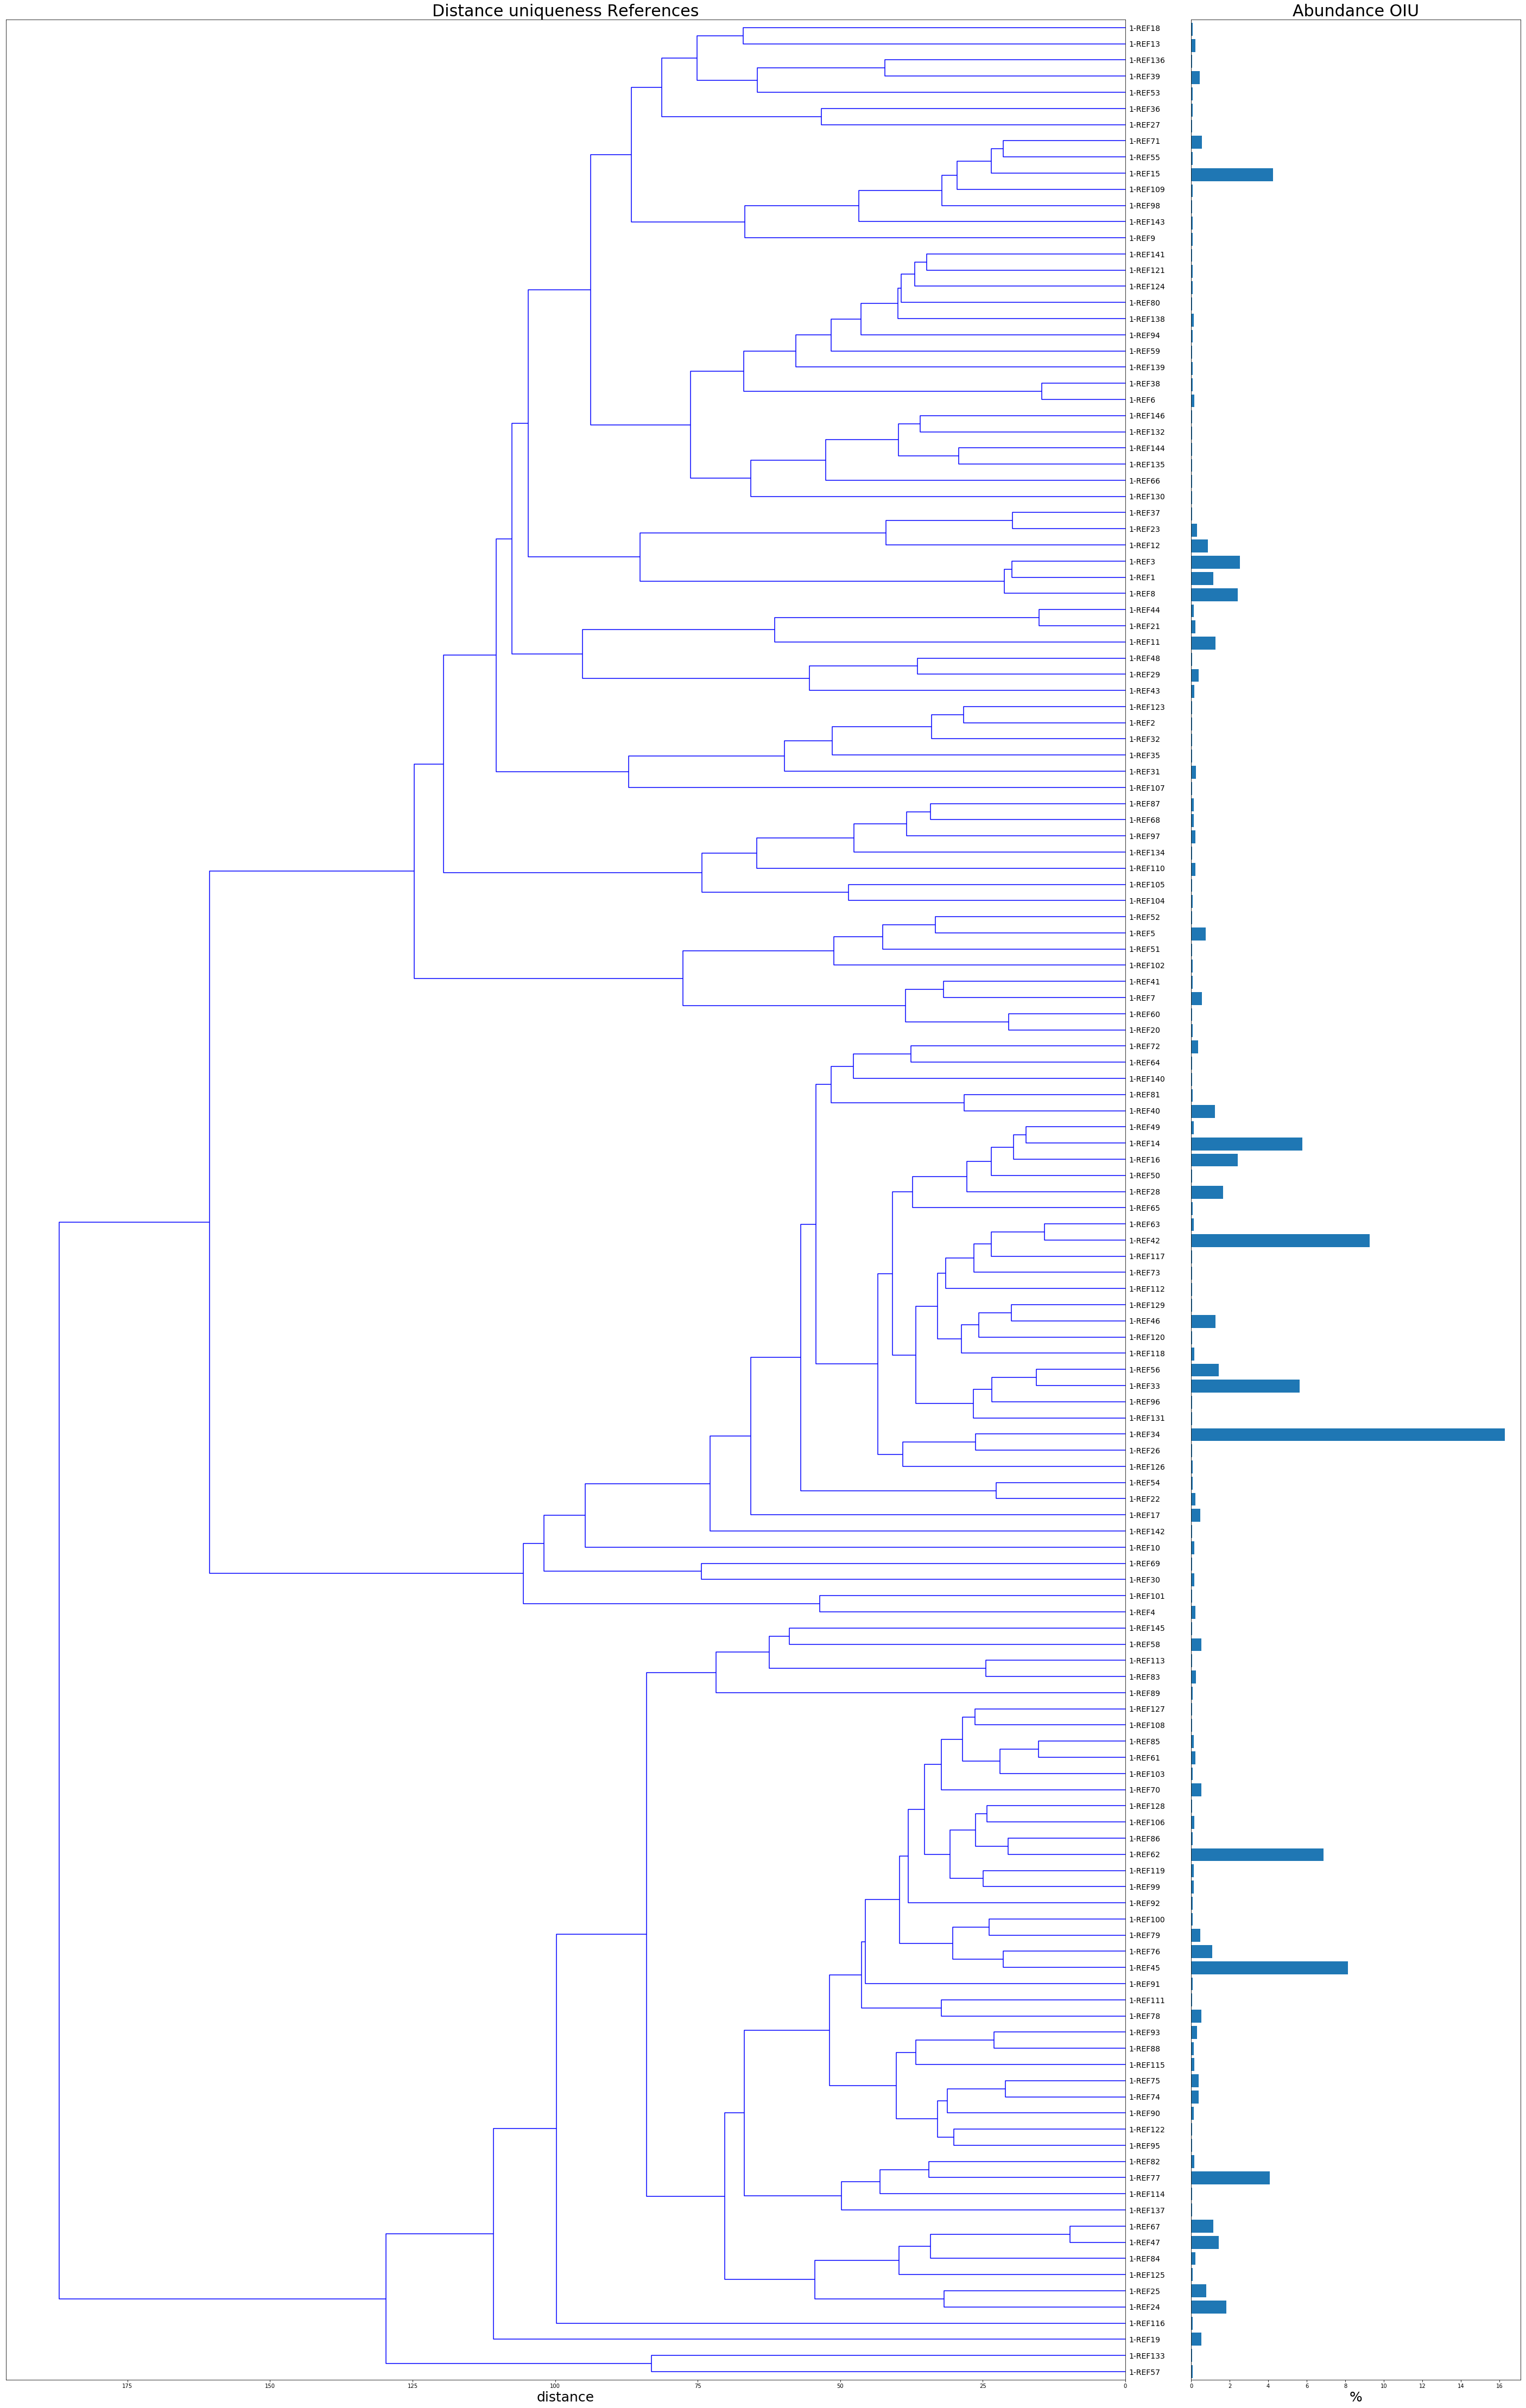

In [2]:
### Import modules 
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import to_tree
import matplotlib.pyplot as plt

# Function to convert linkage to newick
# source : https://stackoverflow.com/questions/28222179/save-dendrogram-to-newick-format/31878514#31878514
def linkage_to_newick(Z, labels):
    """
    Input :  Z = linkage matrix, labels = leaf labels
    Output:  Newick formatted tree string
    """
    tree = to_tree(Z, False)
    def buildNewick(node, newick, parentdist, leaf_names):
        if node.is_leaf():
            return f"{leaf_names[node.id]}:{(parentdist - node.dist)/2}{newick}"
        else:
            if len(newick) > 0:
                newick = f"):{(parentdist - node.dist)/2}{newick}"
            else:
                newick = ");"
            newick = buildNewick(node.get_left(), newick, node.dist, leaf_names)
            newick = buildNewick(node.get_right(), f",{newick}", node.dist, leaf_names)
            newick = f"({newick}" 
            return newick
    return buildNewick(tree, "", tree.dist, labels)

### Input by the user: 
# Provide the validation matrix of the references as a csv file
uni = pd.read_csv('Example_ref_validation_matrix.csv',sep=";",index_col=0)

# Provide the OIU size table as a csv file
bar = pd.read_csv('Example_OIU_abunce_table.csv',sep=";",index_col=0)

## Generate the dendrogram
# Converts the uniquness matrix to a relative distance in uniqueness matrix
uni = uni.astype('float', copy=False)
max = uni.values.max()
f_dis = lambda x: 1 - (x / max)
uni.apply(f_dis)

# Converts distance matrix to linkage matrix
linkage_matrix = linkage(uni,"average")
#Use the index of the validation matrix as labes for the dendrogram and 
labels = uni.index.tolist()
leaf_labels= labels[:]
# Getthe order of the leaf labels from the dendrogram and generate the ordered axis for the barplot
R = dendrogram(linkage_matrix, no_plot=True)
leaves = R ["leaves"]
bar_x= []
for i, value in enumerate(leaves):
    bar_x.append(leaf_labels[value])

## Generate the barplot
bar = bar.astype('float', copy=False)
bar = bar.reindex(bar_x)
bar_y = bar["% samples matched"].tolist()


# Plot the denrogram and the barplot
combined_figure = plt.figure(figsize=(50, 80))

ax1 = combined_figure.add_subplot(1, 4, (1,2.5))
dendrogram(linkage_matrix,labels = labels, orientation= "left",color_threshold = 0,leaf_font_size=14)
plt.title('Distance uniqueness References',fontsize=30)
plt.xlabel('distance',fontsize=25)
ax2 = combined_figure.add_subplot(1, 4, 4)
plt.barh(bar_x,bar_y, align='edge' )
plt.title('Abundance OIU', fontsize=30)
plt.xlabel('%', fontsize=25)

plt.yticks([])
plt.ylim(-0.1,len(bar_y))

combined_figure.show()

# Save the figure as a PDF 
combined_figure.savefig('Distance_uniqueness_matched_number_spectra.pdf',bbox_inches='tight', format='pdf', dpi=600)

# Save the dendrogram to Newick file

newick = linkage_to_newick(linkage_matrix, labels)
f = open('Itol_dedrogram.txt', 'w' )
f.write(newick)
f.close()

